<img src="data/banner.jpg" width="100%">

---------------
Day 4 of the [*ACM SIGCHI Summer School on Computational Interaction*](https://www-edc.eng.cam.ac.uk/summerschool). August 2018, in Cambridge, UK.

# Deep Learning - Part I/III
In this Jupyter notebook you will implement a simple neural network from scratch.
To understand what a NN is we will limit ourselves to a very simple task, namely that of solving the exclusive or (XOR) function. In part II of the course we will then use the acquired concepts (and most of the code) to attack a real HCI problem - that of eye-gaze estimation.


Normally, you would use deep-learning libraries such as [TensorFlow](https://tensorflow.org) or [Caffe](http://caffe.berkeleyvision.org/) to build neural network powered applications. However, for learning purposes it is better to actually implement everything yourself in plain Python and NumPy. 

# Setup
First let's import the necessary libraries and let's configure essential building blocks such as a pseudo-random number generator:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 56

np.random.seed(RANDOM_SEED)

We have now imported and configured useful helper libraries such as [matlibplot](https://matplotlib.org/) for plotting and [NumPy](http://www.numpy.org/) - the workhorse of numerical and scientific programming. If you are not familiar with these you should follow up on the [various](https://docs.scipy.org/doc/numpy/user/quickstart.html) [tutorials](https://cs231n.github.io/python-numpy-tutorial/) available online.

# Activation functions and background

During the introduction you have seen that in deep neural networks every linear layer is followed by a non-linear activation function. Without these neural networks would only be able to approximate affine functions and hence would be a lot less powerful. 
The perceptron algorithm uses a step-function as activation function. However, for various reasons in DL one uses different types of activation functions. One reason is that the activation function should be differentiable and should have a derivative that leads to fast learning rates.

# Sigmoid

In this tutorial we will be working with the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) as activation function. It has several appealing properties: it is bounded, it is fully differentiable and has a positive derivative at any point. Furthermore, the sigmoid function maps real-valued inputs to the (0,1) range. This is useful because it allows us to interpret its output as a probability value. The sigmoid function is defined by: 
$$\sigma(x)=\frac{1}{1+e^{-x}}$$

In order to train our neural network we will also need it's derivative which is given by:
$$\frac{\partial \sigma(x)}{\partial x}=\sigma(x)\cdot(1-\sigma(x))$$


<div style="margin:2em 0.2em;background-color:#eef;border-radius:0.5em;padding:3.5em;padding-bottom:2.7em;color:#444;">
    <div style="color:#55a;font-weight:bold;margin:-1.7em 0 1em -1.7em;">Task 1a</div>
    Implement the sigmoid function and its derivative below.
</div>
<div style="margin:2em 0.2em;margin-top:-2.5em;background-color:#efe;border-radius:0 0 0.5em 0.5em;padding:1.8em;color:#444;">
    <div style="color:#5a5;font-weight:bold;float:left;margin-right:1.5em;">Hint</div>
    You will need to use the function [np.exp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html).
</div>

In [2]:
def sigmoid(x):
  """
  Computes the sigmoid function sigm(input) = 1/(1+exp(-input))
  """
  return 1 / (1 + np.exp(-x))

def sigmoid_(y):
  """
  Computes the derivative of sigmoid funtion. sigmoid(y) * (1.0 - sigmoid(y)). 
  The way we implemented this requires that the input y is already sigmoided
  """
  return y * (1-y)

And to better understand what these do we'll plot them:

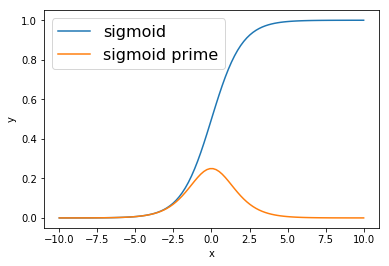

In [3]:
x = np.linspace(-10., 10., num=100)
sig = sigmoid(x)
sig_prime = sigmoid_(sig)

plt.plot(x, sig, label="sigmoid")
plt.plot(x, sig_prime, label="sigmoid prime")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(prop={'size' : 16})
plt.show()

If you need some background info on how we got here check out the full derivation of this [here](http://kawahara.ca/how-to-compute-the-derivative-of-a-sigmoid-function-fully-worked-example/).



# Backpropagation
Before we can build a NN to actually do anything useful, we need a way to train it. The backbone of all things Neural Network training is the backpropagation algorithm. A full treatment goes beyond the scope of this course but when we discussed the MLP we have already seen a simplified version of the backprop algorithm in action.

The NN training algorithm consists of 3 subtasks:


1.   Make a forward pass (to compute the current, most likely incorrect, prediction)
2.   Calculate the error with respect to the ground truth label
3.   Make a backward pass to compute an update of the network's parameters

The final step propagates the error through the network, starting from the final layer. Thus, the weights (network parameters) get updated based on the error, little by little.

If you want to make headway in terms of deep-learning it is important to really understand backprop. Here is a [good summary of the algorithm by Andrew Ng](https://www.youtube.com/watch?v=mOmkv5SI9hU):



In [4]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/mOmkv5SI9hU" frameborder="0" allowfullscreen></iframe>')

# Solving the XOR problem with a NN
Let's now put the pieces we've got so far together to solve a small but non-linear problem first. 

We will try to create a network to properly predict values from the XOR function. Here is its ground truth table:

| Input1 | Input2 | Output |
|--------|--------|--------|
|   0    |   0    |    0   |    
|   0    |   1    |    1   |    
|   1    |   0    |    1   |
|   1    |   1    |    0   | 

The result is only "true" *iff* either of the inputs is "one" but not otherwise.

This can be visualized as follows where *green* represents `1` and *red* represents `0`:

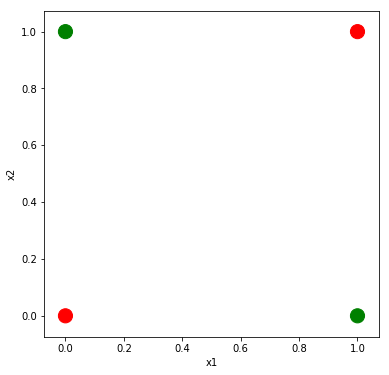

In [5]:
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([ [0],   [1],   [1],   [0]])

# Colors corresponding to class labels y.
colors = ['green' if y_ == 1 else 'red' for y_ in y] 

fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
plt.scatter(X[:,0],X[:,1],s=200,c=colors)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Let's get started by defining our network structure and some NN parameters (often called hyperparameters).
In this case you're supposed to define a NN with a single hidden-layer with three units. The NN also has one input layer with two units and an output layer with a single unit. Below is a picture of the network structure. Each circle indicates one unit, each arrow one weight. The units of the hidden layer are followed by an activation function.
![A picture of a neural network](data/XOR-MLP.png)

<div style="margin:2em 0.2em;background-color:#eef;border-radius:0.5em;padding:3.5em;padding-bottom:2.7em;color:#444;">
    <div style="color:#55a;font-weight:bold;margin:-1.7em 0 1em -1.7em;">Task 1b</div>
    Set the variables `input_size`, `hidden_size`, and `output_size` as appropriate, by referring to the network specification and diagram above.
    <br><br>
    Afterwards, set the correct dimensions for the weights `w_hidden` and `w_output`.
</div>

In [6]:
input_size = 2
hidden_size = 3
output_size = 1

learning_rate = 0.2
epochs = 4001

Now initialize the weights of our network using random numbers. Make sure you use the proper sizes defined above.

In [7]:
w_hidden = np.random.uniform(size=(input_size, hidden_size))
w_output = np.random.uniform(size=(hidden_size, output_size))

Finally, we'll implement the Backprop algorithm in order to train our network. Remember that this consists of three steps:


1.   Forward pass
2.   Error calculation
3.   Backprop and weight update


Linear layers (in this case the output layer) compute their output of the form $\mathbf{x}^\mathrm{T}\mathbf{w}$ and the non-linear (hidden) layer passes this through the activation function $\sigma(\mathbf{x}^\mathrm{T}\mathbf{w})$. Since the outputs of the lower layers are the inputs of the upper layers you need to start computing results bottom-up.

More explicitly, a forward pass (inference) in the above neural network can be represented with two equations. One which outputs hidden layer activations from given input $\mathbf{x}$:

$$\mathbf{a} = \sigma\left(\mathbf{h}\right) = \sigma\left( \mathbf{x}^\mathrm{T}\mathbf{W}_1 \right)$$

and one which calculates the final output:
$$\hat{\mathbf{y}} = \mathbf{a}^\mathrm{T}\mathbf{W}_2$$

<div style="margin:2em 0.2em;background-color:#eef;border-radius:0.5em;padding:3.5em;padding-bottom:2.7em;color:#444;">
    <div style="color:#55a;font-weight:bold;margin:-1.7em 0 1em -1.7em;">Task 1c</div>
    Let's begin by implementing the forward pass in the function named `forward_pass`.
</div>
<div style="margin:2em 0.2em;margin-top:-2.5em;background-color:#efe;border-radius:0 0 0.5em 0.5em;padding:1.8em;color:#444;">
    <div style="color:#5a5;font-weight:bold;float:left;margin-right:1.5em;">Hint</div>
    You may need to use [np.ndarray.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.dot.html) for matrix multiplication.
</div>

In [8]:
def forward_pass(X):
    # Step 1: Calculate weighted average of inputs (shape: 4x10)
    net_hidden = X.dot(w_hidden)
    
    # Step 2: Calculate the result of the sigmoid activation function (shape: 4x10)
    act_hidden = sigmoid(net_hidden)
    
    # Step 3: Calculate output of neural network (shape: 4x1)
    output = act_hidden.dot(w_output)
    
    return act_hidden, output

To compute the weight update we need to:


1.   Compute the derivative of the layer wrt to its input (and pass it on per chain-rule, weighted by the layer's parameters)
2.   Compute the derivative of the hidden-layer wrt to it's weights
3.   Update the weights

For step 1, we must consider how the neural network output is calculated with respect to each weight matrix $\mathbf{W}_1$ and $\mathbf{W}_2$. To give you a starting point, we can remind you that the full neural network calculates:

$$\hat{\mathbf{y}} = \sigma\left( \mathbf{x}^\mathrm{T}\mathbf{W}_1 \right)^\mathrm{T}\mathbf{W}_2$$

A mean-squared error is calculated from this output with,

$$\mathbf{\epsilon} = \| \hat{\mathbf{y}} - \mathbf{y} \|^2_2$$

and then the required gradients can be written as:

$$\frac{\partial\mathbf{\epsilon}}{\partial\mathbf{W}_2}
=\frac{\partial\mathbf{\epsilon}}{\partial\hat{\mathbf{y}}}
\frac{\partial\hat{\mathbf{y}}}{\partial\mathbf{W}_2}$$
and
$$\frac{\partial\mathbf{\epsilon}}{\partial\mathbf{W}_1}
=\frac{\partial\mathbf{\epsilon}}{\partial\hat{\mathbf{y}}}
\frac{\partial\hat{\mathbf{y}}}{\partial\mathbf{a}}
\frac{\partial\mathbf{a}}{\partial\mathbf{h}}
\frac{\partial\mathbf{h}}{\partial\mathbf{W}_1}$$


<br><br>
For step 3, remember that a gradient update for $\mathbf{W}$ given gradient $\nabla\mathbf{\epsilon}\left(\mathbf{W}\right)=\frac{\partial\mathbf{\epsilon}}{\partial\mathbf{W}}$ is done in the following way:

$$\mathbf{W}^\prime = \mathbf{W} - \lambda\cdot\nabla\mathbf{\epsilon}\left(\mathbf{W}\right)$$

where $\lambda$ is the learning rate and $\mathbf{W}^\prime$ are the updated weights.

<div style="margin:2em 0.2em;background-color:#eef;border-radius:0.5em;padding:3.5em;padding-bottom:2.7em;color:#444;">
    <div style="color:#55a;font-weight:bold;margin:-1.7em 0 1em -1.7em;">Task 1d</div>
    Fill in the code to complete a backward-pass, and update the weights `w_output` and `w_hidden`.
</div>
<div style="margin:2em 0.2em;margin-top:-2.5em;background-color:#efe;border-radius:0 0 0.5em 0.5em;padding:1.8em;color:#444;">
    <div style="color:#5a5;font-weight:bold;float:left;margin-right:1.5em;">Hint</div>
    Be wary of matrix dimensions. `w_output` is of size (10x1) whereas `w_hidden` is of size (2x10).
</div>

Epoch 0> Training error: 1.046548
Epoch 200> Training error: 0.426459
Epoch 400> Training error: 0.200687
Epoch 600> Training error: 0.073640
Epoch 800> Training error: 0.025786
Epoch 1000> Training error: 0.010368
Epoch 1200> Training error: 0.005959
Epoch 1400> Training error: 0.004112
Epoch 1600> Training error: 0.003122
Epoch 1800> Training error: 0.002510
Epoch 2000> Training error: 0.002096
Epoch 2200> Training error: 0.001797
Epoch 2400> Training error: 0.001572
Epoch 2600> Training error: 0.001397
Epoch 2800> Training error: 0.001256
Epoch 3000> Training error: 0.001141
Epoch 3200> Training error: 0.001045
Epoch 3400> Training error: 0.000964
Epoch 3600> Training error: 0.000894
Epoch 3800> Training error: 0.000834
Epoch 4000> Training error: 0.000781


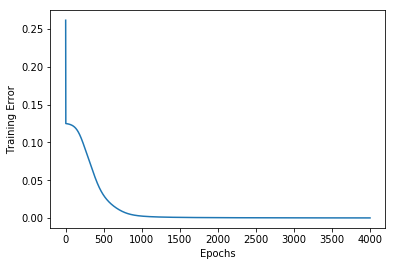

In [9]:
training_errors = []

for epoch in range(epochs):
 
    # Step 1: Forward pass
    act_hidden, output = forward_pass(X)
    
    # Step2: Calculate error
    residual = output - y
    error = 0.5 * (residual ** 2)
    
    # print error every 200 epochs
    if epoch % 200 == 0:
        print('Epoch %d> Training error: %f' % (epoch, np.sum(np.abs(error))))

    # Step 3: Backward pass
    # a) calculate gradient wrt w_output (w2)
    de_do = residual  # TODO
    do_dw2 = act_hidden.T  # TODO
    de_dw2 = do_dw2.dot(de_do)
    
    # b) calculate gradient wrt w_hidden (w1)
    do_da = w_output  # TODO
    da_dh =  sigmoid_(act_hidden) # TODO
    dh_dw1 = X.T  # TODO
    de_dw1 = dh_dw1.dot(de_do.dot(do_da.T) * da_dh)
    
    # c) apply gradients with learning rate applied
    w_output = w_output - learning_rate * de_dw2  # TODO
    w_hidden = w_hidden - learning_rate * de_dw1  # TODO
    
    training_errors.append([epoch, np.mean(error)])

# Plot training error progression over time
training_errors = np.asarray(training_errors)
plt.plot(training_errors[:, 0], training_errors[:, 1]);
plt.xlabel('Epochs');
plt.ylabel('Training Error');

If everything is correct the error should be going down. Play around with epochs and learning rate to get a feeling of what is going on here (make sure to re-run the cell initializing the weights).


# Prediction:
Now that we have a trained neural network let's try and see if it can actually correctly solve the XOR function. Does the following look like what you would expect to be able to see?

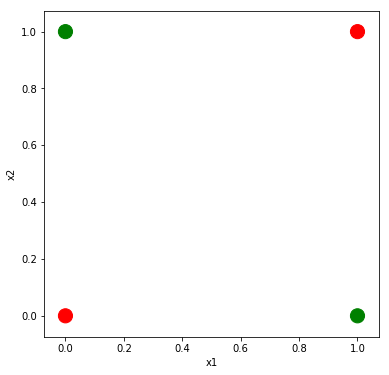

In [10]:
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y_hat = [np.round(forward_pass(x)[1]) for x in X]

# Colors corresponding to class predictions y_hat.
colors = ['green' if y_ == 1 else 'red' for y_ in y_hat] 

fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(6)
plt.scatter(X[:,0],X[:,1],s=200,c=colors)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Hopefully your network should now be able to solve XOR succesfully. Here are a couple of questions to think about:


*   How do we increase the capacity of the network?
*   What happens if we add additional layers to the network?
*   What happens if we pick a much smaller/larger learning rate?
*   When should we stop training? How many epochs is enough?
*   Couldn't we solve this with simple linear regression? Try removing the sigmoid function.


We're now ready to apply the very same ideas to a more complex task. This way to part II of the tutorial: [Otmar b \(Eye Gaze\).ipynb](./Otmar b %28Eye Gaze%29.ipynb)